# Total Variation Regularization Algorithms for Images Denoise

* Implement classical denoising algorithm
* lecture: https://www.edwith.org/optimization2017/lecture/10558/


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

In [2]:
from google.colab import files

In [3]:
print(tf.__version__)

2.4.0


In [4]:
# https://boofcv.org/index.php?title=Example_Wavelet_Noise_Removal
!wget -O img.jpg https://boofcv.org/images/6/66/Kodim17_noisy.jpg

--2021-01-05 00:33:35--  https://boofcv.org/images/6/66/Kodim17_noisy.jpg
Resolving boofcv.org (boofcv.org)... 69.163.186.210
Connecting to boofcv.org (boofcv.org)|69.163.186.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67626 (66K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  66.04K  --.-KB/s    in 0.1s    

2021-01-05 00:33:36 (476 KB/s) - ‘img.jpg’ saved [67626/67626]



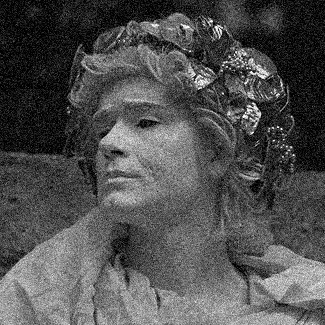

In [5]:
img_path = 'img.jpg'
Image.open(img_path)

In [6]:
img_height, img_width = 180, 180

# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=6cqkPenZIaHl
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  gray = tf.image.rgb_to_grayscale(img)[...,0]
  return gray

In [7]:
def plot_image(img):
  plt.imshow(img.numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
  plt.title('noisy image')
  plt.axis("off")

def plot_images(orig_img, denoised_img):
  plt.figure(figsize=(10, 20))
  imgs = (orig_img, denoised_img)
  labels = ('orig_img', 'denoised_img')
  for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
    plt.title(labels[i])
    plt.axis("off")

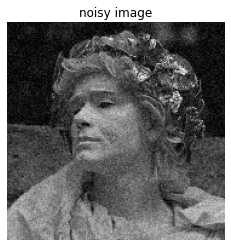

In [9]:
img = process_path(img_path)
plot_image(img)

In [10]:
f = img
u0 = tf.random.normal([img_height, img_width], stddev=1e-6)
p0 = tf.random.normal([img_height, img_width, 2], stddev=1)
p0 = tf.math.l2_normalize(p0, axis=2)

In [11]:
# https://en.wikipedia.org/wiki/Sobel_operator
def gradient(img):
  gradient = tf.image.sobel_edges(img[tf.newaxis, :, :, tf.newaxis])[0, :, :, 0, :]
  dimg_dy = gradient[..., 0]
  dimg_dx = gradient[..., 1]
  return gradient

def div(p):
  gradient = tf.image.sobel_edges(p[tf.newaxis, ...])
  px_dx = gradient[0, :, :, 1, 1]
  py_dy = gradient[0, :, :, 0, 0]
  return px_dx + py_dy

In [12]:
def one_step(f, u, p, LAMBDA, TAU):
  p = p + TAU * gradient(u)
  p = tf.math.l2_normalize(p, axis=2)
  u = f + LAMBDA * div(p)
  return u, p

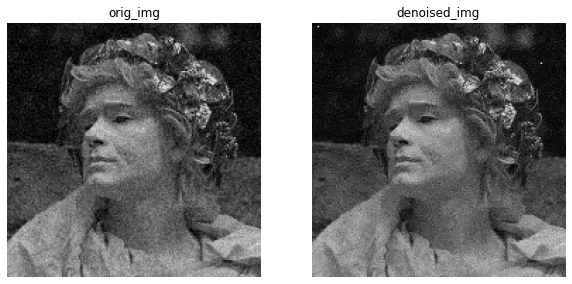

In [13]:
step = 100
LAMBDA = 0.5
TAU = 0.2
u, p = u0, p0
for i in range(step):
  u, p = one_step(f, u, p, LAMBDA, TAU)
plot_images(f, u)

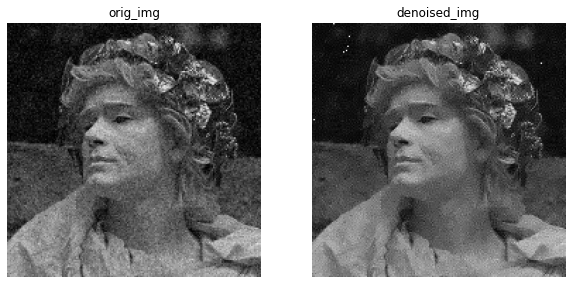

In [14]:
step = 100
LAMBDA = 1.0
TAU = 0.05
u, p = u0, p0
for i in range(step):
  u, p = one_step(f, u, p, LAMBDA, TAU)
plot_images(f, u)